##  Preparation the Dataset (Generating as per the Norms)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
# Constants (Antoine equation parameters)
# Antoine equation: log10(P_sat) = A - B / (T + C)
# Parameters: Ethanol and Water (valid ~0–100°C, units: mmHg)
antoine_params = {
    "ethanol": {"A": 8.20417, "B": 1642.89, "C": 230.3},
    "water": {"A": 8.07131, "B": 1730.63, "C": 233.426}
}
def p_sat(component, T):
    """Return saturation pressure (mmHg) using Antoine equation."""
    A, B, C = antoine_params[component].values()
    return 10 ** (A - B / (T + C))

In [3]:
# Simulation parameters
T_range = np.linspace(60, 100, 50)    # Temperature range (°C)
x1_range = np.linspace(0, 1, 50)      # Mole fraction range
P_total = 760  # Total pressure (1 atm in mmHg)
data = []

for T in T_range:
    for x1 in x1_range:
        x2 = 1 - x1

        # Raoult's Law
        p1 = x1 * p_sat("ethanol", T)
        p2 = x2 * p_sat("water", T)
        P_calc = p1 + p2

        # Normalize pressure to fixed 1 atm condition
        y1 = p1 / P_calc
        y2 = p2 / P_calc

        data.append([x1, T, P_total, y1])

In [4]:
# Convert to DataFrame
df = pd.DataFrame(data, columns=["x1", "T_C", "P_mmHg", "y1"])

In [5]:
# Save dataset
df.to_csv("ethanol_water_vle_dataset.csv", index=False)
print("Dataset generated with shape:", df.shape)

Dataset generated with shape: (2500, 4)


In [7]:
df

,x1,T_C,P_mmHg,y1
0,0.000000,60.0,760,0.000000
1,0.020408,60.0,760,0.046727
2,0.040816,60.0,760,0.091008
3,0.061224,60.0,760,0.133032
4,0.081633,60.0,760,0.172965
...,...,...,...,...
2495,0.918367,100.0,760,0.961758
2496,0.938776,100.0,760,0.971653
2497,0.959184,100.0,760,0.981320
2498,0.979592,100.0,760,0.990767


.

.


Making the dataset size to around 500 samples 

In [8]:
# Target size
target_size = 500

# Define azeotrope region (around x1 = 0.95 for ethanol-water)
azeo_center = 0.95
azeo_window = 0.05  # range [0.90, 1.00]

In [9]:
# Split into two sets: near azeotrope and outside
df_azeo = df[(df["x1"] >= azeo_center - azeo_window) & (df["x1"] <= azeo_center + azeo_window)]
df_other = df[~df.index.isin(df_azeo.index)]

In [10]:
# Sample more points near azeotrope (~40%)
n_azeo = int(target_size * 0.4)
n_other = target_size - n_azeo

df_sampled = pd.concat([
    df_azeo.sample(n=min(n_azeo, len(df_azeo)), random_state=42),
    df_other.sample(n=min(n_other, len(df_other)), random_state=42)
])


In [11]:
# Shuffle
df_sampled = df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

# Save reduced dataset
df_sampled.to_csv("ethanol_water_vle_dataset_500.csv", index=False)

print("Final dataset shape:", df_sampled.shape)
print(df_sampled.head())

Final dataset shape: (500, 4)
         x1        T_C  P_mmHg        y1
0  0.387755  78.775510     760  0.592358
1  0.918367  72.244898     760  0.963008
2  0.795918  73.061224     760  0.900150
3  0.979592  84.489796     760  0.990937
4  0.938776  72.244898     760  0.972589


.

.

Ensureing dense sampling near the azeotropic composition

In [12]:
# Load full dataset
df = pd.read_csv("ethanol_water_vle_dataset.csv")

# Target size
target_size = 500

# Define azeotrope region (ethanol-water ~0.95 mole fraction)
azeo_low, azeo_high = 0.90, 1.00 

In [13]:
# Split dataset
df_azeo = df[(df["x1"] >= azeo_low) & (df["x1"] <= azeo_high)]
df_other = df[df["x1"] < azeo_low]

In [14]:
# Allocate samples (60% azeo, 40% rest)
n_azeo = int(target_size * 0.6)   # ~300
n_other = target_size - n_azeo    # ~200

In [15]:
# Sample with replacement if needed
df_sampled = pd.concat([
    df_azeo.sample(n=n_azeo, replace=True, random_state=42),
    df_other.sample(n=n_other, replace=True, random_state=42)
])

In [16]:
# Shuffle dataset
df_sampled = df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [17]:
# Save reduced dataset
df_sampled.to_csv("ethanol_water_vle_dataset_500.csv", index=False)

In [18]:
print("Final dataset shape:", df_sampled.shape)
print(df_sampled['x1'].describe())  # Check distribution of x1

Final dataset shape: (500, 4)
count    500.000000
mean       0.752367
std        0.305668
min        0.000000
25%        0.530612
50%        0.918367
75%        0.959184
max        1.000000
Name: x1, dtype: float64


In [19]:
df_sampled

,x1,T_C,P_mmHg,y1
0,0.469388,75.510204,760,0.670865
1,0.979592,73.061224,760,0.991068
2,0.204082,86.938776,760,0.368004
3,0.938776,71.428571,760,0.972618
4,1.000000,74.693878,760,1.000000
...,...,...,...,...
495,1.000000,61.632653,760,1.000000
496,0.918367,90.204082,760,0.962186
497,0.081633,80.408163,760,0.169106
498,0.795918,86.122449,760,0.898638


## Staring Building the Model for the Project

In [3]:
import sys
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

In [4]:
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("TensorFlow version:", tf.__version__)
print("Python version:", sys.version)

Pandas version: 2.2.3
NumPy version: 2.2.5
Scikit-learn version: 1.6.1
TensorFlow version: 2.20.0
Python version: 3.13.2 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:14) [MSC v.1929 64 bit (AMD64)]


In [5]:
# Load dataset
df = pd.read_csv("ethanol_water_vle_dataset_500.csv")

df

,x1,T_C,P_mmHg,y1
0,0.469388,75.510204,760,0.670865
1,0.979592,73.061224,760,0.991068
2,0.204082,86.938776,760,0.368004
3,0.938776,71.428571,760,0.972618
4,1.000000,74.693878,760,1.000000
...,...,...,...,...
495,1.000000,61.632653,760,1.000000
496,0.918367,90.204082,760,0.962186
497,0.081633,80.408163,760,0.169106
498,0.795918,86.122449,760,0.898638


In [9]:
# Features and target
X = df[["x1", "T_C", "P_mmHg"]].values
y = df["y1"].values.reshape(-1, 1)

X , y

(array([[4.69387755e-01, 7.55102041e+01, 7.60000000e+02],
        [9.79591837e-01, 7.30612245e+01, 7.60000000e+02],
        [2.04081633e-01, 8.69387755e+01, 7.60000000e+02],
        ...,
        [8.16326531e-02, 8.04081633e+01, 7.60000000e+02],
        [7.95918367e-01, 8.61224490e+01, 7.60000000e+02],
        [9.59183673e-01, 9.67346939e+01, 7.60000000e+02]], shape=(500, 3)),
 array([[0.67086532],
        [0.99106772],
        [0.36800426],
        [0.97261776],
        [1.        ],
        [0.        ],
        [0.800632  ],
        [0.97170619],
        [1.        ],
        [0.52329631],
        [0.97233318],
        [0.96186395],
        [0.7838576 ],
        [0.99091858],
        [0.54753481],
        [0.92051089],
        [0.87825217],
        [0.96343661],
        [0.37089213],
        [0.82275895],
        [0.08755973],
        [0.83597319],
        [0.96296945],
        [0.20767735],
        [0.98153378],
        [0.93137037],
        [0.79397203],
        [0.97197416],
     

In [10]:
# Normalize inputs (0–1 scaling)
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

In [11]:
# Split dataset (70% train, 15% val, 15% test)
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)


In [13]:
# Build deep optimized ANN (10 hidden layers)
model = models.Sequential()
model.add(layers.Input(shape=(3,)))  # Inputs: (x1, T, P)

for _ in range(10):
    model.add(layers.Dense(256, activation="relu", 
                           kernel_regularizer=regularizers.l2(1e-5)))
    model.add(layers.BatchNormalization())   # Normalize activations
    model.add(layers.Dropout(0.3))           # Prevent overfitting


In [14]:
# Output layer (sigmoid to enforce 0 ≤ y1 ≤ 1)
model.add(layers.Dense(1, activation="sigmoid"))

In [15]:
# Compile with optimizer and loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

In [16]:
# Callbacks: early stopping + learning rate scheduler
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=1e-6)
]

# If the validation loss doesn’t improve for 50 consecutive epochs, stop training.

Roll back to the best weights seen so far.

In [17]:
# Train model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=2000,
                    batch_size=64,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 420ms/step - loss: 0.2213 - mae: 0.3613 - val_loss: 0.1586 - val_mae: 0.3473 - learning_rate: 0.0010
Epoch 2/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.2065 - mae: 0.3365 - val_loss: 0.1284 - val_mae: 0.3038 - learning_rate: 0.0010
Epoch 3/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.1530 - mae: 0.2645 - val_loss: 0.1079 - val_mae: 0.2662 - learning_rate: 0.0010
Epoch 4/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1072 - mae: 0.2016 - val_loss: 0.0970 - val_mae: 0.2423 - learning_rate: 0.0010
Epoch 5/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0973 - mae: 0.1799 - val_loss: 0.0930 - val_mae: 0.2318 - learning_rate: 0.0010
Epoch 6/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0789 - mae: 0.1541 - val_loss: 0.0900 - val_mae: 0.2217 - learning_rate: 0.0010
Epoch 7/2000
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0626 - mae: 0.1342 - val_loss: 0.0879 - val_mae: 0.2116 - learning_rate: 0.0010
Epoch 8/200

# So, at epoch 128 your model probably reached its best validation performance. By epoch 178 (128 + 50 patience), it saw no improvement → stopped.

In [18]:
# Evaluate model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"✅ Test MSE: {loss:.6f}, Test MAE: {mae:.6f}")

✅ Test MSE: 0.024339, Test MAE: 0.026060


In [19]:
# Save trained model
model.save("ANN_VLE_Deep_Optimized.h5")

In [20]:
# Example prediction near azeotrope
sample = np.array([[0.95, 78.0, 760]])  # (x1=0.95, T=78°C, P=1 atm)
sample_scaled = scaler_X.transform(sample)
pred_y1 = scaler_y.inverse_transform(model.predict(sample_scaled))
print("Predicted vapor mole fraction (y1):", pred_y1[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
Predicted vapor mole fraction (y1): 0.9689472


# Evaluating the model

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

I didnt want to retrain the model just evaluate and predict on the dataset

In [27]:
# Reload dataset and trained model
df = pd.read_csv("ethanol_water_vle_dataset_500.csv")
model = load_model("ANN_VLE_Deep_Optimized.h5", compile=False)

X = df[["x1", "T_C", "P_mmHg"]].values
y_true = df["y1"].values.reshape(-1, 1)

In [28]:
# Scale inputs (use the same scaler from training!)
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)


In [29]:
# ANN Predictions
y_pred_scaled = model.predict(X_scaled)
y_pred = y_pred_scaled  # Already in [0,1] because sigmoid

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step  


# --- 1. Parity Plot ---

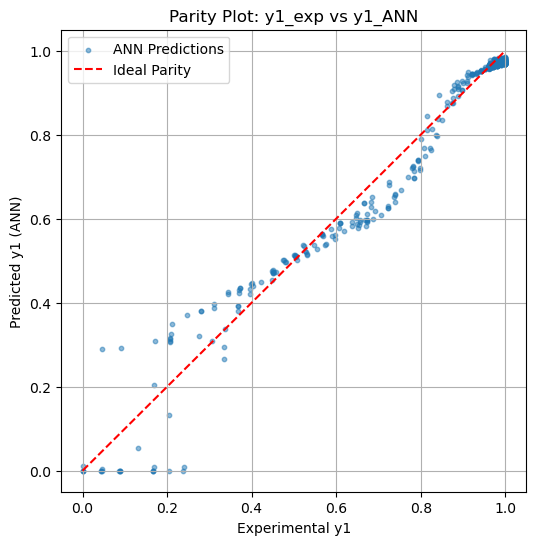

In [30]:
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.5, s=10, label="ANN Predictions")
plt.plot([0,1], [0,1], "r--", label="Ideal Parity")
plt.xlabel("Experimental y1")
plt.ylabel("Predicted y1 (ANN)")
plt.title("Parity Plot: y1_exp vs y1_ANN")
plt.legend()
plt.grid(True)
plt.show()

# --- 2. Detect Azeotrope (y1 ≈ x1) ---

In [32]:
x1_scan = np.linspace(0, 1, 200).reshape(-1, 1)
T_fixed = np.full_like(x1_scan, 78.0)  # Fix near azeotrope temp
P_fixed = np.full_like(x1_scan, 760)   # 1 atm

X_scan = np.hstack([x1_scan, T_fixed, P_fixed])
X_scan_scaled = scaler_X.transform(X_scan)

y_scan = model.predict(X_scan_scaled)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [34]:
# Find where y1 ≈ x1
diff = np.abs(y_scan.flatten() - x1_scan.flatten())
azeo_idx = np.argmin(diff)

x1_azeo = float(x1_scan[azeo_idx][0])
y1_azeo = float(y_scan[azeo_idx][0])
T_azeo = float(T_fixed[0])

print(f"🔍 Predicted Azeotrope: x1 ≈ {x1_azeo:.3f}, y1 ≈ {y1_azeo:.3f}, T ≈ {T_azeo:.2f} °C")

🔍 Predicted Azeotrope: x1 ≈ 0.000, y1 ≈ 0.000, T ≈ 78.00 °C


C:\Users\amanp\AppData\Local\Temp\ipykernel_24344\790940725.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_azeo = float(T_fixed[0])


# --- 3. Compare with Reference Data ---

In [35]:
print("📌 Reference Ethanol-Water Azeotrope: x1 ≈ 0.95, T ≈ 78.2 °C (at 1 atm)")

📌 Reference Ethanol-Water Azeotrope: x1 ≈ 0.95, T ≈ 78.2 °C (at 1 atm)


# --- 4. Compare with Raoult’s Law (Baseline) ---

In [36]:
def p_sat_ethanol(T):
    A, B, C = 8.20417, 1642.89, 230.3
    return 10 ** (A - B / (T + C))

def p_sat_water(T):
    A, B, C = 8.07131, 1730.63, 233.426
    return 10 ** (A - B / (T + C))

y_raoult = []
for x in x1_scan.flatten():
    p1 = x * p_sat_ethanol(78)
    p2 = (1 - x) * p_sat_water(78)
    y1 = p1 / (p1 + p2)
    y_raoult.append(y1)

In [37]:
# Plot ANN vs Raoult’s Law

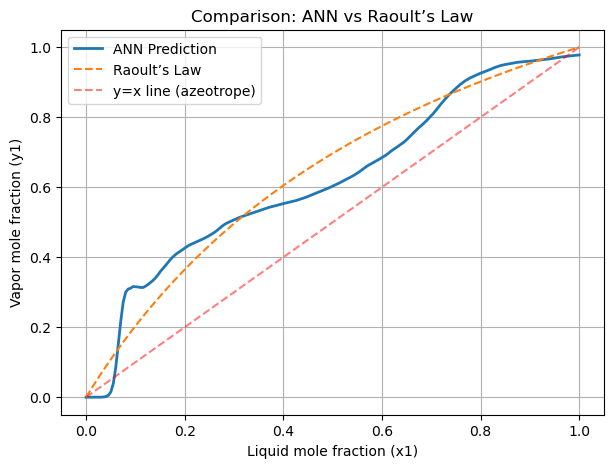

In [38]:
plt.figure(figsize=(7,5))
plt.plot(x1_scan, y_scan, label="ANN Prediction", linewidth=2)
plt.plot(x1_scan, y_raoult, label="Raoult’s Law", linestyle="--")
plt.plot([0,1],[0,1], "r--", alpha=0.5, label="y=x line (azeotrope)")
plt.xlabel("Liquid mole fraction (x1)")
plt.ylabel("Vapor mole fraction (y1)")
plt.title("Comparison: ANN vs Raoult’s Law")
plt.legend()
plt.grid(True)
plt.show()